In [1]:
#| default_exp tbats

THIS IS VERSION 2 OF THE TBATS MODEL (INCOMPLETE)

# TBATS model 

In [2]:
#| export
import os
import numpy as np 
from numba import njit 
from scipy.optimize import minimize_scalar, minimize 
import statsmodels.api as sm 
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.linalg import eig
from numpy.polynomial.polynomial import Polynomial
from statsforecast.arima import auto_arima_f, arima_string
from time import time 

/Users/marianamenchero/miniforge3/envs/nixtla-stats/lib/python3.10/site-packages/statsforecast/core.py:25: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
#| export 
# Global variables 
NOGIL = os.environ.get('NUMBA_RELEASE_GIL', 'False').lower() in ['true']
CACHE = os.environ.get('NUMBA_CACHE', 'False').lower() in ['true']

## Load data 

In [4]:
#| hide 
# AirPassengers 
from statsforecast.utils import AirPassengers as ap 

# USAccDeaths
deaths = np.array([9007,  8106,  8928,  9137, 10017, 10826, 11317, 10744,  9713,  9938,  9161,  8927,
7750,  6981,  8038,  8422,  8714,  9512, 10120,  9823,  8743,  9129,  8710,  8680,
8162,  7306,  8124,  7870,  9387,  9556, 10093,  9620,  8285,  8466,  8160,  8034,
7717,  7461,  7767,  7925,  8623,  8945, 10078,  9179,  8037,  8488,  7874,  8647,
7792,  6957,  7726,  8106,  8890,  9299, 10625,  9302,  8314,  8850,  8265,  8796,
7836,  6892,  7791,  8192,  9115,  9434, 10484,  9827,  9110,  9070,  8633,  9240])

# Electricity consumption
import pandas as pd 
elec_df = pd.read_csv('/Users/marianamenchero/Documents/tbats/data/PJMW_hourly.csv')
elec = elec_df['PJMW_MW']
elec = elec[0:(24*7*3)]
elec = np.array(elec)

# Calls 
calls_df = pd.read_csv('/Users/marianamenchero/Documents/tbats/data/calls_data.csv')
calls = calls_df['calls']
calls = calls[-2001:]
calls = np.array(calls)

# M4 data 
train = pd.read_csv('/Users/marianamenchero/Documents/tbats/data/Hourly-train.csv')
uid = 'H50'
m4_df = train.loc[train['unique_id'] == uid]
y = m4_df['y'].values
seasonal_periods = np.array([24])

## Box-Cox Transformation

In [5]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def guer_cv(lam, x, season_length): 
    
   """Minimize this funtion to find the optimal parameter for the Box-Cox transformation."""
   period = np.round(np.max(season_length)) 
   n = len(x) 
   nyears = int(np.floor(n/period))
   nobs = np.floor(nyears*period)
   m = int(n-nobs)
   xmat = x[m:n].reshape((nyears, period))

   xmean = np.full(xmat.shape[0], fill_value = np.nan)
   for k in range(xmat.shape[0]): 
      xmean[k] = np.nanmean(xmat[k])

   xsd = np.full(xmat.shape[0], fill_value = np.nan)
   for k in range(xmat.shape[0]): 
      vals = xmat[k]
      svar = (vals-np.nanmean(vals))**2 
      svar = np.sum(svar)/len(svar) 
      xsd[k] = np.sqrt(svar) 

   xrat = xsd/(xmean**(1-lam))

   sd = (xrat-np.nanmean(xrat))**2 
   sd = np.nansum(sd)/(len(sd)-1)
   sd = np.sqrt(sd)
   
   return sd/np.nanmean(xrat)

In [6]:
#| exporti
def guerrero(x, season_length, lower=0, upper=1): 
    
    """Finds optimal paramater for Box-Cox transformation using Guerrero's method"""
    
    if np.any(x < 0): 
        raise ValueError("Guerrero's method for selecting a Box-Cox parameter (w) is for strictly positive data")
    
    max_freq = np.max(season_length)
    if len(x) <= 2*max_freq: 
        res = 1
    else: 
        w = 0 # initial guess 
        opt = minimize_scalar(guer_cv, w, args = (x, season_length), method = 'bounded', bounds = (lower, upper))
        res = opt.x

    return res

In [7]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def BoxCox(y, BoxCox_lambda): 
    
    """Applies Box-Cox transformation with parameter BoxCox_lambda"""

    if BoxCox_lambda == 0: 
        z = np.log(y)
    else: 
        z = np.sign(y)*((np.abs(y)**BoxCox_lambda)-1)
        z = z/BoxCox_lambda
        
    return z

In [8]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def InverseBoxCox(z, BoxCox_lambda): 
    
    """Inverts Box-Cox transformation with parameter BoxCox_lambda"""

    if BoxCox_lambda == 0: 
        y = np.exp(z) 
    else: 
        sign = np.sign(BoxCox_lambda*z+1)
        y = np.abs(BoxCox_lambda*z+1)**(1/BoxCox_lambda)
        y = sign*y 
        
    return y 

## Functions 

### find_harmonics

In [9]:
#| exporti
def find_harmonics(y, seasonal_periods, k):

    # Compute a 2 x m moving average to estimate the trend 
    m = seasonal_periods[k]
    window_size = 2 * m
    data = pd.DataFrame({'value': y})
    f_t = data['value'].rolling(window = window_size, center = True).mean()
    
    # Obtain an approximation of seasonal component using z_t = y_t - f_t 
    data['f_t'] = f_t
    data['z_t'] = data['value']-data['f_t']

    # Drop missing values (due to the moving average)
    data.dropna(inplace = True) 

    if data.empty:
        return 1

    # Approximate the seasonal component using trigonometric terms
    t = np.arange(len(data))
    if m % 2 == 0: 
        max_harmonics = int(m/2)
    else: 
        max_harmonics = int((m-1)/2)

    max_harmonics = min(max_harmonics, len(data))
    
    aic = np.inf
    num_harmonics = 0
    for h in range(1,max_harmonics+1): 
        columns = []
        for i in range(1, h+1):
            data[f'cos_{i}'] = np.cos(2*np.pi*i*t/m)
            data[f'sin_{i}'] = np.sin(2*np.pi*i*t/m)
            columns.extend([f'cos_{i}', f'sin_{i}'])
        
        # Perform regression to estimate the coefficients
        X = data[columns]
        y = data['z_t']
        model = sm.OLS(y, X).fit()
        new_aic = model.aic 

        if new_aic < aic: 
            aic = new_aic
            num_harmonics = h  
        else: 
            break

    if num_harmonics == 0: 
        num_harmonics += 1 
    
    return num_harmonics

### initial_parameters 

In [10]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def initial_parameters(seasonal_periods, k_vector, use_trend, use_damped_trend, ar_coeffs, ma_coeffs): 

    alpha = 0.09 

    if use_trend: 
        adj_beta = 1 
        beta = 0.05
        b = 0 
        if use_damped_trend: 
            phi = 0.999 
        else: 
            phi = 1
    else: 
        adj_beta = 0 
        beta = None 
        b = None 
        phi = None

    if seasonal_periods is not None: 
        gamma_one_v = np.zeros(len(k_vector))
        gamma_two_v = np.zeros(len(k_vector))
        s_vector = np.zeros(2*np.sum(k_vector)) 
    # else:  # for this to happen, seasonal_periods must be None, which is not possible in StatsForecast
    #     gamma_one_v = None 
    #     gamma_two_v = None 
    #     s_vector = None 

    if ar_coeffs is not None: 
        d_vector = np.zeros(len(ar_coeffs))
    else: 
        d_vector = None
    if ma_coeffs is not None:
        epsilon_vector = np.zeros(len(ma_coeffs))  
    else: 
        epsilon_vector = None 

    return alpha, adj_beta, beta, b, phi, gamma_one_v, gamma_two_v, s_vector, d_vector, epsilon_vector 

### makeXMatrix

In [11]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def makeXMatrix(b, s_vector, d_vector, epsilon_vector): 

    # x = (l_t, b_t, s_vector, d_vector, epsilon_vector)
    x = np.array([0.0]) 
    if b is not None: 
        x = np.append(x, b)
    if s_vector is not None: 
        x = np.concatenate((x, s_vector))
    if d_vector is not None: 
        x = np.concatenate((x, d_vector)) 
    if epsilon_vector is not None: 
        x = np.concatenate((x, epsilon_vector))
    
    return x 

### findPQ

In [12]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def findPQ(ar_coeffs, ma_coeffs): 
    if ar_coeffs is not None: 
        p = len(ar_coeffs) 
    else: 
        p = 0 
    if ma_coeffs is not None: 
        q = len(ma_coeffs) 
    else: 
        q = 0 
    return p, q

### makeTBATSWMatrix

In [13]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def makeTBATSWMatrix(phi, k_vector, ar_coeffs, ma_coeffs, tau):
    
    # w_transpose = (1, phi, a, varphi, theta)
    p, q = findPQ(ar_coeffs, ma_coeffs)
    adj_phi = 0 
    numCols = 1

    if phi is not None: 
        adj_phi += 1
        numCols += 1

    numCols += tau+p+q

    w_transpose = np.zeros((1,numCols))

    position = adj_phi
    for s in range(len(k_vector)): 
        w_transpose[0, position+1:position+k_vector[s]+1] = 1
        position += 2*k_vector[s]

    w_transpose[0,0] = 1 

    if phi is not None: # equivalent to asking adj_phi == 1
        w_transpose[0,1] = phi

    if ar_coeffs is not None: 
        w_transpose[0, adj_phi+tau+1:adj_phi+tau+p+1] = ar_coeffs

    if ma_coeffs is not None: 
        w_transpose[0, adj_phi+tau+p+1:adj_phi+tau+p+q+1] = ma_coeffs

    return w_transpose

### makeTBATSGMatrix 

In [14]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def makeTBATSGMatrix(k_vector, alpha, adj_beta, beta, gamma_one_v, gamma_two_v, p, q, tau):
    
    # g = (alpha, beta, gamma_bold, 1, 0_{p-1}, 1, 0_{q-1})
    g = np.zeros((1+adj_beta+2*np.sum(k_vector)+p+q,1))

    g[0,0] = alpha 

    if beta is not None: 
        g[1,0] = beta 

    gamma_bold = np.ones((1, 2*sum(k_vector)))
    endPos = 0 
    for i in range(len(k_vector)): 
        gamma_bold[0, endPos:endPos+k_vector[i]] = gamma_one_v[i]
        gamma_bold[0, endPos+k_vector[i]:endPos+2*k_vector[i]] = gamma_two_v[i]
        endPos += 2*k_vector[i]

    g[1+adj_beta:1+adj_beta+gamma_bold.shape[1],0] = gamma_bold

    if p != 0: 
        g[1+adj_beta+tau,0] = 1 
    if q != 0: 
        g[1+adj_beta+tau+p,0] = 1

    return g, gamma_bold

### makeTBATSFMatrix 

In [15]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def makeTBATSFMatrix(phi, tau, alpha, beta, ar_coeffs, ma_coeffs, gamma_bold, seasonal_periods, k_vector): 

    # Alpha row 
    F = np.array([[1.0]])
    if phi is not None: 
        F = np.hstack((F, np.array([[phi]])))
    F = np.hstack((F, np.zeros((1,tau))))
    if ar_coeffs is not None: 
        alpha_varphi = alpha*ar_coeffs
        alpha_varphi = alpha_varphi.reshape((1,len(alpha_varphi)))
        F = np.hstack((F, alpha_varphi))
    if ma_coeffs is not None: 
        alpha_theta = alpha*ma_coeffs
        alpha_theta = alpha_theta.reshape((1,len(alpha_theta)))
        F = np.hstack((F, alpha_theta))   

    # Beta row 
    if beta is not None: 
        beta_row = np.array([[0.0, phi]])
        beta_row = np.hstack((beta_row, np.zeros((1,tau))))
        if ar_coeffs is not None: 
            beta_varphi = beta*ar_coeffs
            beta_varphi = beta_varphi.reshape((1,len(beta_varphi)))
            beta_row = np.hstack((beta_row, beta_varphi))
        if ma_coeffs is not None: 
            beta_theta = beta*ma_coeffs
            beta_theta = beta_theta.reshape((1,len(beta_theta)))
            beta_row = np.hstack((beta_row, beta_theta))
        F = np.vstack((F, beta_row))

    # Seasonal row 
    seasonal_row = np.zeros((tau,1))

    if phi is not None: 
        seasonal_row = np.hstack((seasonal_row, np.zeros((tau,1))))

    A = np.zeros((tau, tau))
    pos = 0 
    for i in range(len(k_vector)):
        ck = np.zeros((k_vector[i], k_vector[i]))
        sk = np.zeros((k_vector[i], k_vector[i]))
        for j in range(1,k_vector[i]+1): 
            lambda_j = (2*np.pi*j)/seasonal_periods[i]
            ck[j-1,j-1] = np.cos(lambda_j)
            sk[j-1,j-1] = np.sin(lambda_j)
        top = np.hstack((ck, sk))
        bottom = np.hstack((-sk, ck)) 
        Ak = np.vstack((top, bottom))
        A[pos:pos+2*k_vector[i],pos:pos+2*k_vector[i]] = Ak
        pos += 2*k_vector[i]
    seasonal_row = np.hstack((seasonal_row, A))

    if ar_coeffs is not None: 
        varphi = ar_coeffs.reshape((1, ar_coeffs.shape[0]))
        B = np.dot(np.transpose(gamma_bold), varphi)
        seasonal_row = np.hstack((seasonal_row, B))

    if ma_coeffs is not None: 
        theta = ma_coeffs.reshape((1, ma_coeffs.shape[0]))
        C = np.dot(np.transpose(gamma_bold), theta)
        seasonal_row = np.hstack((seasonal_row, C))

    F = np.vstack((F, seasonal_row))

    # ARMA submatrix 
    if ar_coeffs is not None:
        p = len(ar_coeffs)
        ar_rows = np.zeros((p, 1))
        
        if phi is not None:
            ar_rows = np.hstack((ar_rows, ar_rows))
            
        ar_seasonal_zeros = np.zeros((p, tau)) # seasonal part
        ar_rows = np.hstack((ar_rows, ar_seasonal_zeros))
        
        ident = np.eye(p - 1)
        ident = np.hstack((ident, np.zeros(((p - 1), 1))))

        ar_part = np.vstack((ar_coeffs.reshape((1, ar_coeffs.shape[0])), ident))
        ar_rows = np.hstack((ar_rows, ar_part))
        
        if ma_coeffs is not None:
            q = len(ma_coeffs)
            ma_in_ar = np.zeros((p, q))
            ma_in_ar[0, :] = ma_coeffs
            ar_rows = np.hstack((ar_rows, ma_in_ar))
        
        F = np.vstack((F, ar_rows))

    if ma_coeffs is not None:
        q = len(ma_coeffs)
        ma_rows = np.zeros((q, 1))
        
        if phi is not None:
            ma_rows = np.hstack((ma_rows, ma_rows))

        ma_seasonal = np.zeros((q, tau))
        ma_rows = np.hstack((ma_rows, ma_seasonal))
        
        if ar_coeffs is not None:
            p = len(ar_coeffs)
            ar_in_ma = np.zeros((q, p))
            ma_rows = np.hstack((ma_rows, ar_in_ma))
        
        ident = np.eye(q - 1)
        ident = np.hstack((ident, np.zeros(((q - 1), 1))))
        ma_part = np.vstack((np.zeros((1, q)), ident))
        ma_rows = np.hstack((ma_rows, ma_part))
        
        F = np.vstack((F, ma_rows))
    
    return F

### calcTBATSFaster 

In [16]:
#| exporti
def calcTBATSFaster(y_trans, w_transpose, g, F, x_nought): 

    n = y_trans.shape[0] 
    dimF = F.shape[0] 
    
    yhat = np.zeros((1,n))
    e = np.zeros((1,n))
    x = np.zeros((len(x_nought),n))

    yhat[0,0] = np.dot(w_transpose, x_nought).reshape(())
    e[0,0] = y_trans[0]-yhat[0,0] 
    x[:,0] = np.dot(F, x_nought)+(g*e[0,0]).reshape((dimF,))

    for j in range(1,y_trans.shape[0]): 
        yhat[:, j] = np.dot(w_transpose, x[:, (j-1)])
        e[0,j] = y_trans[j]-yhat[0,j]
        x[:,j] = (np.dot(F,x[:,(j-1)]).reshape((dimF,1))+g*e[0,j]).reshape((dimF,))
        
    return yhat, e, x

### extract_params

In [17]:
#| exporti
def extract_params(params, use_boxcox, use_trend, use_damped_trend, use_arma_errors, seasonal_periods, p, q): 
    if use_boxcox: 
        BoxCox_lambda = params[0]
        alpha = params[1]
        index = 2 
    else: 
        BoxCox_lambda = None 
        alpha = params[0]
        index = 1
    if use_trend: 
        beta = params[index]
        index += 1
        if use_damped_trend: 
            phi = params[index]
            index += 1
        else: 
            phi = None 
    else: 
        beta = None 
        phi = None
    gamma_one_v = params[index:index+len(seasonal_periods)]
    gamma_two_v = params[index+len(seasonal_periods):index+2*len(seasonal_periods)]
    index += 2*len(seasonal_periods)
    if use_arma_errors: # if arma_errors = True, then p or q must be non-zero 
        if p != 0 and q != 0: 
            ar_coeffs = params[index:index+p]
            ma_coeffs = params[index+p:index+p+q]
        elif p != 0: 
            ar_coeffs = params[index:index+p]
            ma_coeffs = None
        else: 
            # q != 0:
            ar_coeffs = None
            ma_coeffs = params[index:index+q]
    else: 
        ar_coeffs = None 
        ma_coeffs = None 

    return BoxCox_lambda, alpha, beta, phi, gamma_one_v, gamma_two_v, ar_coeffs, ma_coeffs

### updateTBATSWMatrix

In [18]:
#| exporti
def updateTBATSWMatrix(w_transpose, phi, tau, ar_coeffs, ma_coeffs, p, q): 
    adjBeta = 0 

    if phi is not None: 
        adjBeta = 1 
        w_transpose[0,1] = phi 

    if p != 0: 
        w_transpose[0, adjBeta+tau+1:adjBeta+tau+p+1] = ar_coeffs
        if q != 0: 
            w_transpose[0, adjBeta+tau+p+1:adjBeta+tau+p+q+1] = ma_coeffs
    elif q != 0: 
        # here p = 0 
        w_transpose[0, adjBeta+tau+1:adjBeta+tau+q+1] = ma_coeffs
    
    return(w_transpose)

### updateTBATSGMatrix 

In [19]:
#| exporti
def updateTBATSGMatrix(g, gamma_bold, alpha, beta, k_vector, gamma_one_v, gamma_two_v):
    # This function also updates gamma_bold  
    adjBeta = 0 
    g[0,0] = alpha 
    
    if beta is not None: 
        g[1,0] = beta 
        adjBeta = 1 

    endPos = 0 
    numK = len(k_vector) 
    
    for i in range(numK): 
        gamma_bold[0, endPos:endPos+k_vector[i]] = gamma_one_v[i]
        gamma_bold[0, endPos+k_vector[i]:endPos+2*k_vector[i]] = gamma_two_v[i]
        endPos += 2*k_vector[i]
    
    g[(adjBeta+1):(adjBeta+gamma_bold.shape[1]+1), 0] = np.transpose(gamma_bold).reshape((gamma_bold.shape[1],))
    
    return g 

### updateTBATSFMatrix 

In [20]:
#| exporti
def updateTBATSFMatrix(F, phi, alpha, beta, gamma_bold, ar_coeffs, ma_coeffs, p, q, tau):
    if beta is not None: 
        F[0,1] = phi 
        F[1,1] = phi 
        betaAdjust = 1
    else: 
        betaAdjust = 0 
    if ar_coeffs is not None:
        F[0, (betaAdjust+tau+1):(betaAdjust+tau+p+1)] = alpha*ar_coeffs
        if betaAdjust == 1:  
            F[1, (betaAdjust+tau+1):(betaAdjust+tau+p+1)] = beta*ar_coeffs 
        if tau > 0: 
            B = np.dot(gamma_bold.reshape((gamma_bold.shape[1],1)), ar_coeffs.reshape((1,ar_coeffs.shape[0])))
            F[(1+betaAdjust):(betaAdjust+tau+1), (betaAdjust+tau+1):(betaAdjust+tau+p+1)] = B 
        F[betaAdjust+tau+1,(betaAdjust+tau+1):(betaAdjust+tau+p+1)] = ar_coeffs 
    if ma_coeffs is not None: 
        F[0, (betaAdjust+tau+p+1):(betaAdjust+tau+p+q+1)] = alpha*ma_coeffs 
        if betaAdjust == 1:  
            F[1, (betaAdjust+tau+p+1):(betaAdjust+tau+p+q+1)] = beta*ma_coeffs
        if tau > 0: 
            C = np.dot(gamma_bold.reshape((gamma_bold.shape[1],1)),ma_coeffs.reshape((1,ma_coeffs.shape[0]))) 
            F[(1+betaAdjust):(betaAdjust+tau+1), (betaAdjust+tau+p+1):(betaAdjust+tau+p+q+1)] = C 
        if ar_coeffs is not None: 
            F[betaAdjust+tau+1,(betaAdjust+tau+p+1):(betaAdjust+tau+p+q+1)] = ma_coeffs 

    return F 

### checkAdmissibility

In [21]:
#| exporti
def checkAdmissibility(BoxCox_lambda, bc_lower_bound, bc_upper_bound, alpha, beta, phi, ar_coeffs, ma_coeffs, D): 
    if BoxCox_lambda is not None: 
        if (BoxCox_lambda < bc_lower_bound) or (BoxCox_lambda > bc_upper_bound): 
            return False 

    # These 2 conditions are not in the R code, but they're added because of the definition of smoothing paramters (alpha & beta). 
    if (alpha < 0) or (alpha > 1): 
        return False
    
    if beta is not None: 
        if (beta < 0) or (beta > 1): 
            return False
    # --------------------------------

    if phi is not None: 
        if (phi < 0.8) or (phi > 1): 
            return False 
            
    if ar_coeffs is not None:
        ar_lags = np.where(np.abs(ar_coeffs) > 1e-08)[0]
        if len(ar_lags) > 0:
            pval = max(ar_lags) + 1  
            poly_coeffs = [1] + [-coef for coef in ar_coeffs[:pval]]
            roots = Polynomial(poly_coeffs).roots()
            if np.min(np.abs(roots)) < 1 + 1e-2:
                return False
            
    if ma_coeffs is not None:
        ma_lags = np.where(np.abs(ma_coeffs) > 1e-08)[0]
        if len(ma_lags) > 0:
            qval = max(ma_lags) + 1  
            poly_coeffs = [1] + list(ma_coeffs[:qval])
            roots = Polynomial(poly_coeffs).roots()
            if np.min(np.abs(roots)) < 1 + 1e-2:
                return False
  
    D_eigen_values = eig(D, right=False)
    
    return np.all(abs(D_eigen_values) < 1+1e-2)

### calcLikelihoodTBATS

In [22]:
#| exporti
def calcLikelihoodTBATS(params, use_boxcox, use_trend, use_damped_trend, use_arma_errors, y, y_trans, seasonal_periods, k_vector, tau, w_transpose, F, g, gamma_bold, x_nought, bc_lower_bound, bc_upper_bound, p, q): 
    
    BoxCox_lambda, alpha, beta, phi, gamma_one_v, gamma_two_v, ar_coeffs, ma_coeffs = extract_params(params, use_boxcox, use_trend, use_damped_trend, use_arma_errors, seasonal_periods, p, q)

    w_transpose = updateTBATSWMatrix(w_transpose, phi, tau, ar_coeffs, ma_coeffs, p, q) 
    g = updateTBATSGMatrix(g, gamma_bold, alpha, beta, k_vector, gamma_one_v, gamma_two_v)
    F = updateTBATSFMatrix(F, phi, alpha, beta, gamma_bold, ar_coeffs, ma_coeffs, p, q, tau)

    _, e, _ = calcTBATSFaster(y_trans, w_transpose, g, F, x_nought)

    n = len(y_trans)
    if use_boxcox: 
        log_likelihood = n*np.log(np.nansum(e**2))-2*(BoxCox_lambda-1)*np.nansum(np.log(y)) 
    else: 
        log_likelihood = n*np.log(np.nansum(e**2))

    D = F-np.dot(g, w_transpose)

    if checkAdmissibility(BoxCox_lambda, bc_lower_bound, bc_upper_bound, alpha, beta, phi, ar_coeffs, ma_coeffs, D): 
        return log_likelihood 
    else: 
        return 10**20
    

## TBATS model 

### tbats_model_generator 

In [23]:
def tbats_model_generator(y, seasonal_periods, k_vector, use_boxcox, bc_lower_bound, bc_upper_bound, use_trend, use_damped_trend, use_arma_errors, ar_coeffs, ma_coeffs): 

    # Initial Box-Cox transformation (if required)
    if use_boxcox: 
        BoxCox_lambda = 0 # This is the initial value used in the thesis 
        y_trans = BoxCox(y, BoxCox_lambda)
    else: 
        BoxCox_lambda = None
        y_trans = y 

    p, q = findPQ(ar_coeffs, ma_coeffs)

    # select starting params 
    alpha, adj_beta, beta, b, phi, gamma_one_v, gamma_two_v, s_vector, d_vector, epsilon_vector = initial_parameters(seasonal_periods, k_vector, use_trend, use_damped_trend, ar_coeffs, ma_coeffs)

    # seed states 
    x_nought = makeXMatrix(b, s_vector, d_vector, epsilon_vector)

    # tau 
    tau = 2*np.sum(k_vector)

    # Create w_transpose, g, and F matrices 
    w_transpose = makeTBATSWMatrix(phi, k_vector, ar_coeffs, ma_coeffs, tau)
    g, gamma_bold = makeTBATSGMatrix(k_vector, alpha, adj_beta, beta, gamma_one_v, gamma_two_v, p, q, tau)
    F = makeTBATSFMatrix(phi, tau, alpha, beta, ar_coeffs, ma_coeffs, gamma_bold, seasonal_periods, k_vector)
    D = F - np.dot(g, w_transpose)

    # Find seed states 
    _, e, x = calcTBATSFaster(y_trans, w_transpose, g, F, x_nought)

    w_tilda_transpose = np.zeros((y.shape[0], w_transpose.shape[1]))
    w_tilda_transpose[0,:] = w_transpose

    for k in range(1, w_tilda_transpose.shape[0]): 
        w_tilda_transpose[k,:] = np.dot(w_tilda_transpose[k-1,:], D)

    if p != 0 or q!= 0: 
        end_cut = w_tilda_transpose.shape[1] 
        start_cut = end_cut-(p+q)    
        new_cols = np.arange(0, start_cut, 1)
        w_tilda_transpose = w_tilda_transpose[:, new_cols]

    model = sm.OLS(e.reshape((e.shape[1],1)), w_tilda_transpose).fit()
    x_nought = model.params

    if (p != 0) or (q != 0):
        arma_seed_states = np.zeros((p+q,))
        x_nought = np.concatenate((x_nought, arma_seed_states))

    # Optimization 
    # Create vector with parameters 
    if use_boxcox: 
        params = np.concatenate([np.array([BoxCox_lambda]), np.array([alpha])]) 
    else:  
        params = np.array([alpha])
    if beta is not None:  
        params = np.concatenate([params, np.array([beta])])
    if phi is not None: 
        params = np.concatenate([params, np.array([phi])]) 
    params = np.concatenate([params, gamma_one_v, gamma_two_v])
    if ar_coeffs is not None: 
        params = np.concatenate([params, ar_coeffs])
    if ma_coeffs is not None: 
        params = np.concatenate([params, ma_coeffs])

    # Solve optimization problem
    optim_params = minimize(calcLikelihoodTBATS,
                            params,
                            args = (use_boxcox, use_trend, use_damped_trend, use_arma_errors, y, y_trans, seasonal_periods, k_vector, tau, w_transpose, F, g, gamma_bold, x_nought, bc_lower_bound, bc_upper_bound, p, q), 
                            method = 'Nelder-Mead'
                            #options = {'maxiter': 2000, 'disp': False}
                            ).x
    
    _, optim_alpha, optim_beta, optim_phi, optim_gamma_one_v, optim_gamma_two_v, optim_ar_coeffs, optim_ma_coeffs = extract_params(optim_params, use_boxcox, use_trend, use_damped_trend, use_arma_errors, seasonal_periods, p, q)

    w_transpose = updateTBATSWMatrix(w_transpose, optim_phi, tau, optim_ar_coeffs, optim_ma_coeffs, p, q)
    g = updateTBATSGMatrix(g, gamma_bold, optim_alpha, optim_beta, k_vector, optim_gamma_one_v, optim_gamma_two_v)
    F = updateTBATSFMatrix(F, optim_phi, optim_alpha, optim_beta, gamma_bold, optim_ar_coeffs, optim_ma_coeffs, p, q, tau)

    fitted, errors, x = calcTBATSFaster(y_trans, w_transpose, g, F, x_nought)

    sigma2 = np.sum(errors*errors)/len(y_trans)

    # Calculate log-likelihood 
    if use_boxcox: 
        log_likelihood = len(y_trans)*np.log(np.nansum(errors**2))-2*(BoxCox_lambda-1)*np.nansum(np.log(y)) 
    else: 
        log_likelihood = len(y_trans)*np.log(np.nansum(errors**2))

    kval = len(optim_params)+x_nought.shape[0]
    aic = log_likelihood+2*kval 
    aic 

    res = {
        'fitted': fitted, 
        'errors': errors, 
        'sigma2': sigma2, 
        'aic': aic,
        'optim_params': optim_params,
        'BoxCox_lambda': BoxCox_lambda,
        'F': F, 
        'w_transpose': w_transpose,
        'g': g,
        'x': x,
        'k_vector': k_vector,
        }

    return res 

### tbats_model 

In [24]:
def tbats_model(y, seasonal_periods, use_boxcox, bc_lower_bound, bc_upper_bound, use_trend, use_damped_trend, use_arma_errors): 

    # Sort seasonal periods 
    seasonal_periods = np.sort(seasonal_periods)

    # Check if there are missing values 
    indices = np.where(np.isnan(y))[0]
    if len(indices) > 0: 
        max_index = indices[-1]
        y = y[max_index+1:len(y)]

    # Check if there are negative values
    if np.any(y < 0): 
            use_boxcox = False 

    # Check if there is a trend
    adf = adfuller(y, regression = 'ct')
    if adf[1] <= 0.05: 
        print('The time series is trend-stationary')
        use_trend = False
        use_damped_trend = False

    # Choose the number of harmonics 
    k_vector = np.zeros(len(seasonal_periods)).astype(int)

    for k in range(len(seasonal_periods)): 
        k_vector[k] = find_harmonics(y, seasonal_periods, k)

    # First model - No ARMA errors 
    ar_coeffs = None 
    ma_coeffs = None 

    best_model = tbats_model_generator(y, seasonal_periods, k_vector, use_boxcox, bc_lower_bound, bc_upper_bound, use_trend, use_damped_trend, use_arma_errors, ar_coeffs, ma_coeffs)
    best_model['description'] = "Model without ARMA errors"

    # Second model 
    # Uses ARMA errors and the k_vector from the first model
    if use_arma_errors: 
        try: 
            errors = best_model['errors'][0] # ARMA errors from first model 
            with np.errstate(invalid="ignore"):
                fit = auto_arima_f(errors)
            p = int(arima_string(fit)[6])
            q = int(arima_string(fit)[10])
            if p != 0: 
                ar_coeffs = np.zeros((p,)) 
            else: 
                ar_coeffs = None 
            if q != 0: 
                ma_coeffs = np.zeros((q,))
            else: 
                ma_coeffs = None

            model_arma_errors = tbats_model_generator(y, seasonal_periods, k_vector, use_boxcox, bc_lower_bound, bc_upper_bound, use_trend, use_damped_trend, use_arma_errors, ar_coeffs, ma_coeffs)

            if model_arma_errors['aic'] <= best_model['aic']: 
                best_model = model_arma_errors
                best_model['description'] = 'Model with ARMA errors'
        except:
            return best_model
    
    return best_model 

### tbats_forecast

In [25]:
def tbats_forecast(mod, h): # this function is the same as bats_forecast
    fcst = np.zeros((h,))
    xx = np.zeros((mod['x'].shape[0], h))

    fcst[0] = np.dot(mod['w_transpose'], mod['x'][:,-1])
    xx[:,0] = np.dot(mod['F'], mod['x'][:,-1]) 

    if h > 1: 
        for t in range(1,h): 
            xx[:,t] = np.dot(mod['F'], xx[:,(t-1)])
            fcst[t] = np.dot(mod['w_transpose'], xx[:,(t-1)])
    
    res = {'mean': fcst}

    return res

### Example 

In [26]:
# y = elec
# seasonal_periods = np.array([24, 24*7])

y = ap
seasonal_periods = np.array([12])

In [34]:
use_boxcox = True
bc_lower_bound = 0
bc_upper_bound = 1
use_trend = True
use_damped_trend = True
use_arma_errors = True

In [35]:
mod = tbats_model(y, seasonal_periods, use_boxcox, bc_lower_bound, bc_upper_bound, use_trend, use_damped_trend, use_arma_errors) 

In [36]:
fitted_trans = InverseBoxCox(mod['fitted'], mod['BoxCox_lambda'])
fitted_trans = fitted_trans.reshape((fitted_trans.shape[1],))

In [37]:
h = 24
fcst = tbats_forecast(mod, h)
forecast = InverseBoxCox(fcst['mean'], mod['BoxCox_lambda'])

/var/folders/0g/82x8ml8d55q88d1yftnwk_jw0000gn/T/ipykernel_13420/1899317433.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fcst[0] = np.dot(mod['w_transpose'], mod['x'][:,-1])
/var/folders/0g/82x8ml8d55q88d1yftnwk_jw0000gn/T/ipykernel_13420/1899317433.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fcst[t] = np.dot(mod['w_transpose'], xx[:,(t-1)])


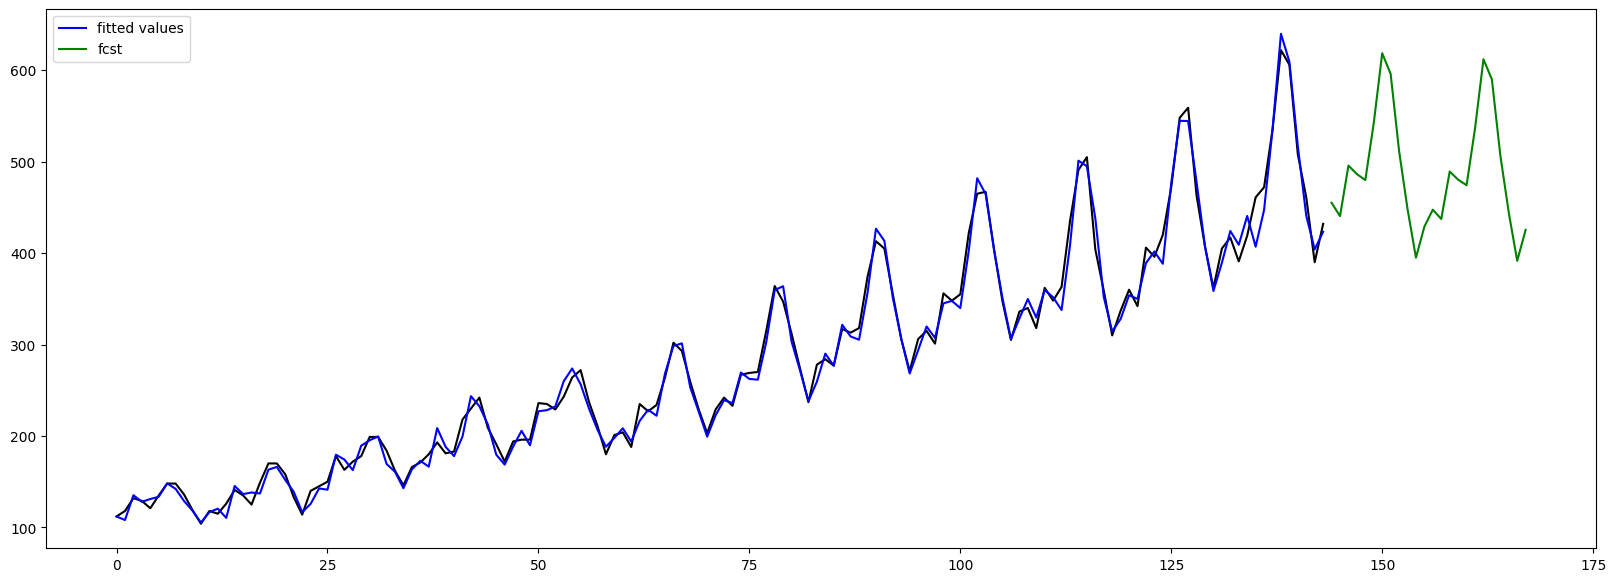

In [38]:
fig, ax = plt.subplots(1, 1, figsize = (20,7))
plt.plot(np.arange(0, len(y)), y, color='black')
plt.plot(np.arange(0, len(y)), fitted_trans, color='blue', label = "fitted values")
plt.plot(np.arange(len(y), len(y)+h), forecast, color = 'green', label = 'fcst')
plt.legend()

In [ ]:
# This should be the model with a damped trend, but there is no trend! In R you can see the trend. 
# Also, this implementation breaks when use_damped_trend = False 